# Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [3]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

# Baseline

## File paths

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [77]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


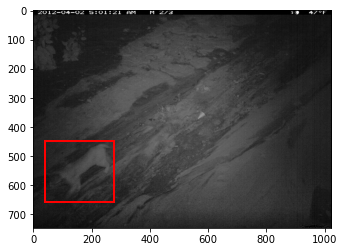

In [76]:
i = 500

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Utils

In [20]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [21]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target

## Pre-trained models

In [27]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with only the last layer to train

In [ ]:
# def get_model_from_pretrained(num_classes):

#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#     for param in model.parameters(): # to freeze all existing weights
#         param.requires_grad = False

#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     return model

### Model with more layers to train

In [28]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    for param in model.

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

### Create the dataloaders
To load the data of the dataset efficiently for the model

In [30]:
train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [31]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data = CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [32]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data = CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

## Loading/Importing a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_data/model.pt'))
optimizer.load_state_dict(torch.load('saved_data/optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_data/scheduler.pt'))
model.eval()

## Logs utils

#### Train logs utils

In [415]:
import time

In [416]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values

In [417]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [418]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [419]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [420]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [421]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [422]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

## Training the model

In [430]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 15

In [431]:
# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [432]:
# Defining the train function
def train(dataloader, num_epochs, save_logs=True, save_model=True, print_freq=100):
    
    all_train_logs = []
    all_cis_valid_logs = []
    all_trans_valid_logs = []

    for epoch in range(num_epochs):
        
        # train for one epoch, printing every 100 images
        train_logs = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        all_train_logs.append(train_logs)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the validation dataset after training one epoch
        for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                trans_loss_dict = model(images, targets)
                trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
                all_trans_valid_logs.append(trans_loss_dict)


        for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                cis_loss_dict = model(images, targets)
                cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
                all_cis_valid_logs.append(cis_loss_dict)
    
    filetime = time.strftime("%Y%m%d_%H%M%S")
    
    if save_logs:
        
        # save the train, cis valid and trans valid logs
        train_logs_to_json(all_train_logs, filetime)
        cis_valid_logs_to_json(all_cis_valid_logs, filetime)
        trans_valid_logs_to_json(all_trans_valid_logs, filetime)
        
    if save_model:
        
        # save the model, the optimizer and the scheduler
        torch.save(model.state_dict(), 'saved_models/' + filetime + 'model.pt')
        torch.save(optimizer.state_dict(), 'saved_models/' + filetime + 'optimizer.pt')
        torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + 'scheduler.pt')
    
    return all_train_logs, all_trans_valid_logs, all_cis_valid_logs


#### This next cell starts the training of the model

In [451]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=trans_valid_dataloader, num_epochs=1)

Epoch: [0]  [  0/154]  eta: 0:02:28  lr: 0.000000  loss: 0.1512 (0.1512)  loss_classifier: 0.0346 (0.0346)  loss_box_reg: 0.0497 (0.0497)  loss_objectness: 0.0624 (0.0624)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 0.9675  data: 0.2430  max mem: 4220
Epoch: [0]  [100/154]  eta: 0:00:51  lr: 0.000000  loss: 0.1254 (0.1325)  loss_classifier: 0.0353 (0.0377)  loss_box_reg: 0.0511 (0.0527)  loss_objectness: 0.0268 (0.0378)  loss_rpn_box_reg: 0.0036 (0.0042)  time: 0.9863  data: 0.2726  max mem: 4220
Epoch: [0]  [153/154]  eta: 0:00:00  lr: 0.000000  loss: 0.1268 (0.1330)  loss_classifier: 0.0371 (0.0379)  loss_box_reg: 0.0533 (0.0529)  loss_objectness: 0.0255 (0.0378)  loss_rpn_box_reg: 0.0037 (0.0044)  time: 0.9773  data: 0.2746  max mem: 4220
Epoch: [0] Total time: 0:02:26 (0.9508 s / it)


### Saving the last training logs to variables
##### Ensures that if you hit the training cell, you don't lose the variables containing the logs from the last run

In [394]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

## Saving every logs from training to json files

In [395]:
# Saves the log with the same time
train_logs_to_json(last_train_logs)
trans_valid_logs_to_json(last_trans_valid_logs)
cis_valid_logs_to_json(last_cis_valid_logs)

## Saving the model

In [345]:
# save the model, the optimizer and the scheduler
filetime = time.strftime("%Y%m%d_%H%M%S")

torch.save(model.state_dict(), 'saved_models/' + filetime + 'model.pt')
torch.save(optimizer.state_dict(), 'saved_models/' + filetime + 'optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + 'scheduler.pt')

## Exploration of the raw logs
##### Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [434]:
all_train_logs[0].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x2076a131b48>,
             'loss': <utils.SmoothedValue at 0x2076a125548>,
             'loss_classifier': <utils.SmoothedValue at 0x2057d364448>,
             'loss_box_reg': <utils.SmoothedValue at 0x207690f67c8>,
             'loss_objectness': <utils.SmoothedValue at 0x2076a132a48>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x2076a132808>})

In [435]:
all_train_logs[0].meters['loss_box_reg'].global_avg

0.045604636602360894

#### Here we check the amount of logs per epoch for each categories and the type

In [436]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0288)}, {'loss_box_reg': tensor(0.0463)}, {'loss_objectness': tensor(0.0554)}, {'loss_rpn_box_reg': tensor(0.0052)}]
total length: 2505
--------
per epoch length: 167.0


In [437]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0300)}, {'loss_box_reg': tensor(0.0497)}, {'loss_objectness': tensor(0.0173)}, {'loss_rpn_box_reg': tensor(0.0030)}]
total length: 2310
--------
per epoch length: 154.0


## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

We can import logs or use the ones from training.

### OPTIONAL - Can load some logs right here

In [438]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '30' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

### Put the last trained logs into convenient list variables
##### Converts the logs to lists and the tensors to numpy

In [443]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

## Results

In [445]:
# To confirm that the data is loaded properly
len(train_logs)

15

In [446]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])

In [447]:
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

In [448]:
# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

### Plots

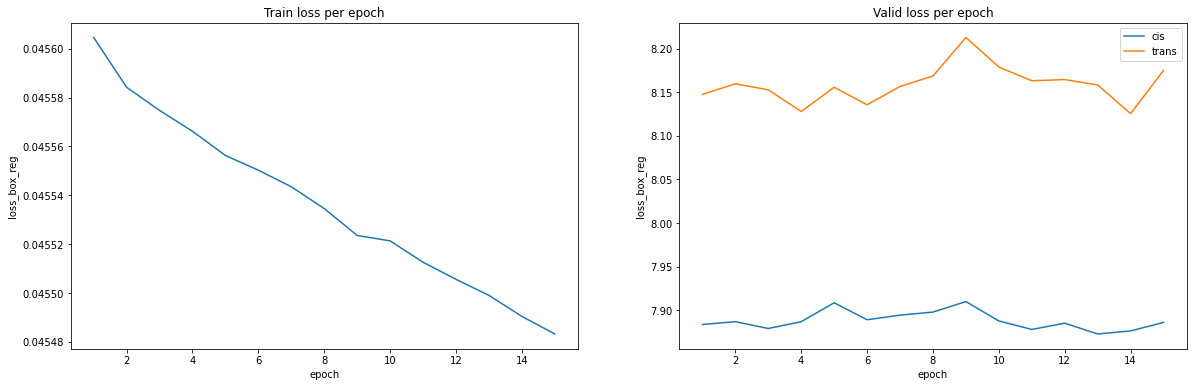

In [449]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

## Make Predictions with a model

### OPTIONAL - Can load a model right here to test the predictions quickly
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_data/model.pt'))
optimizer.load_state_dict(torch.load('saved_data/optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_data/scheduler.pt'))
model.eval()

### Predictions

In [407]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

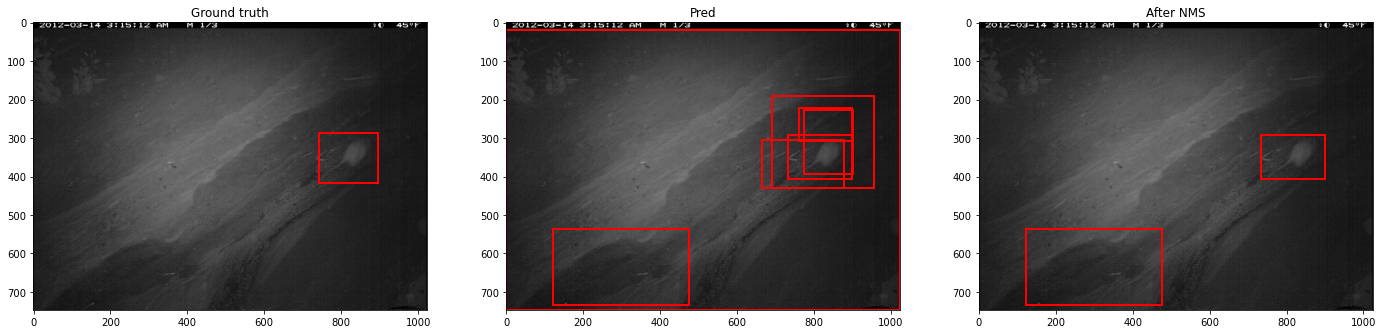

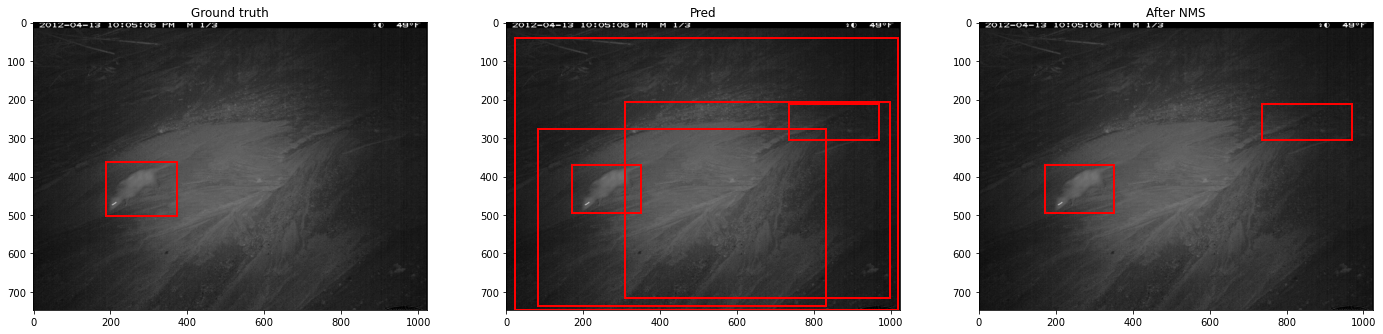

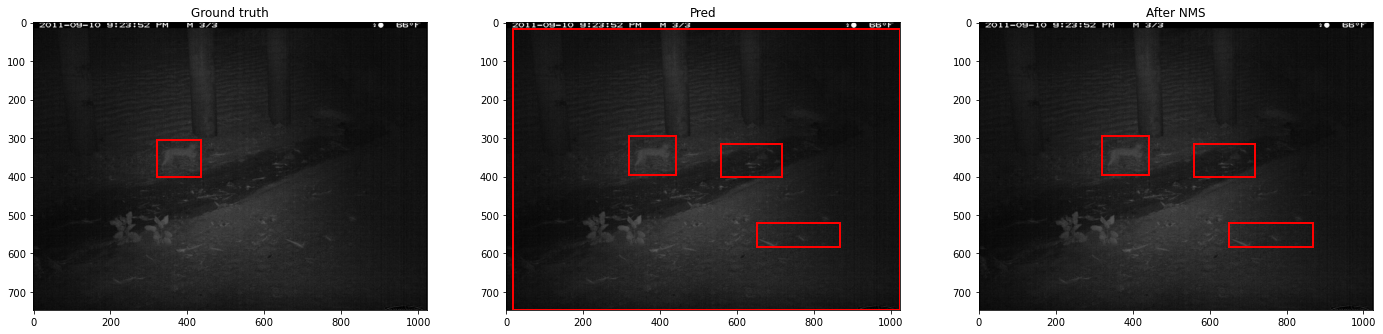

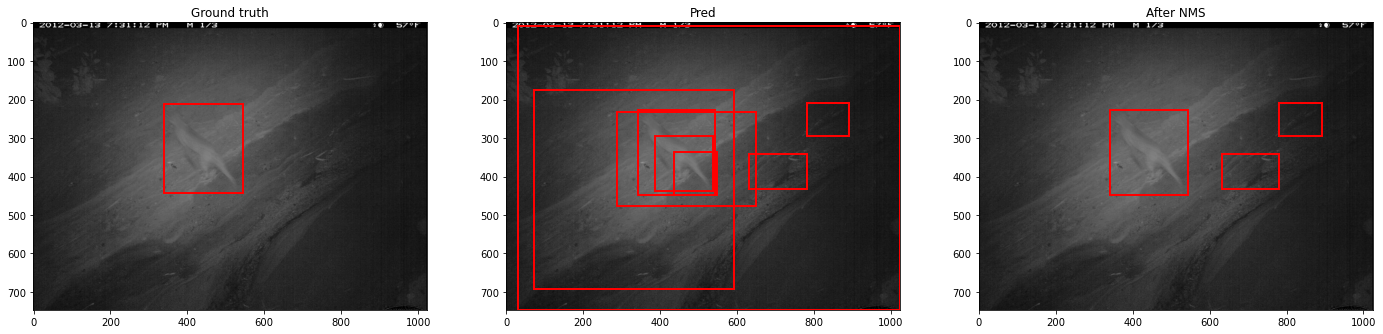

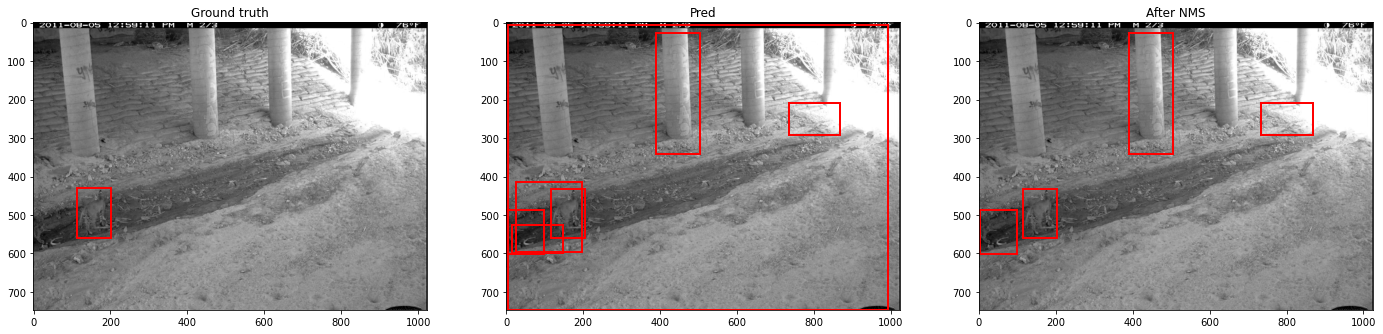

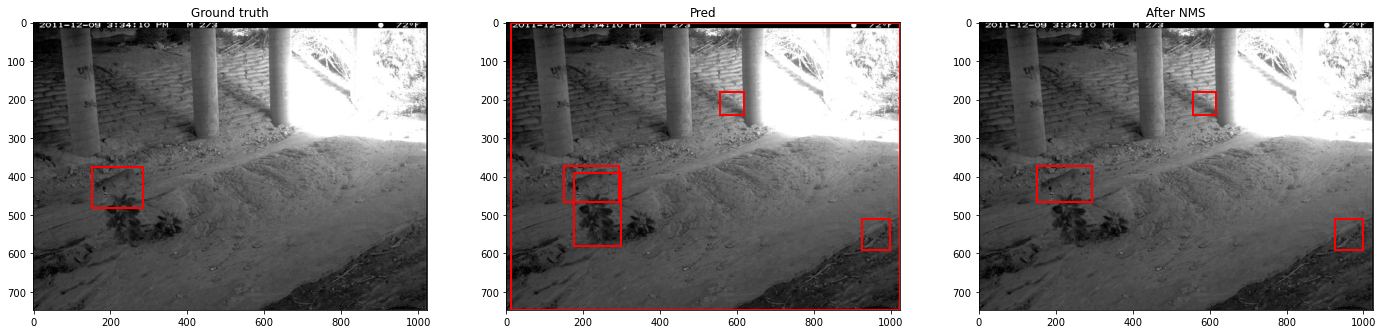

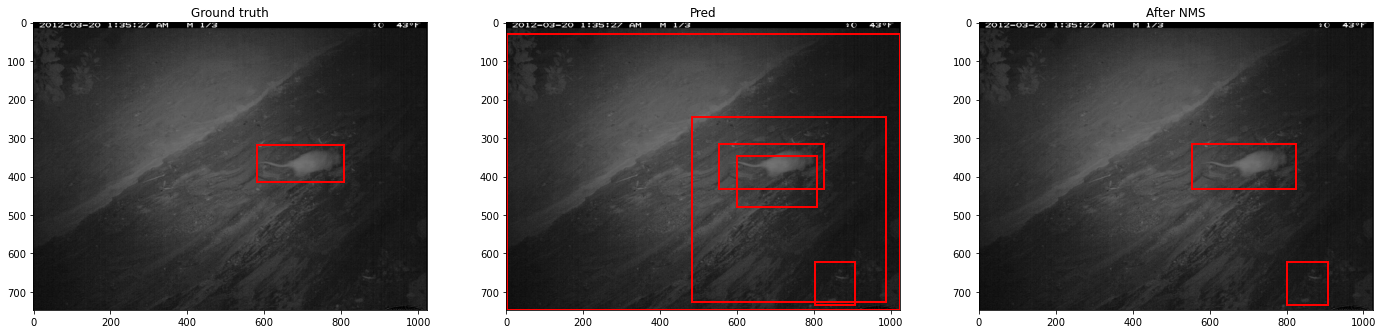

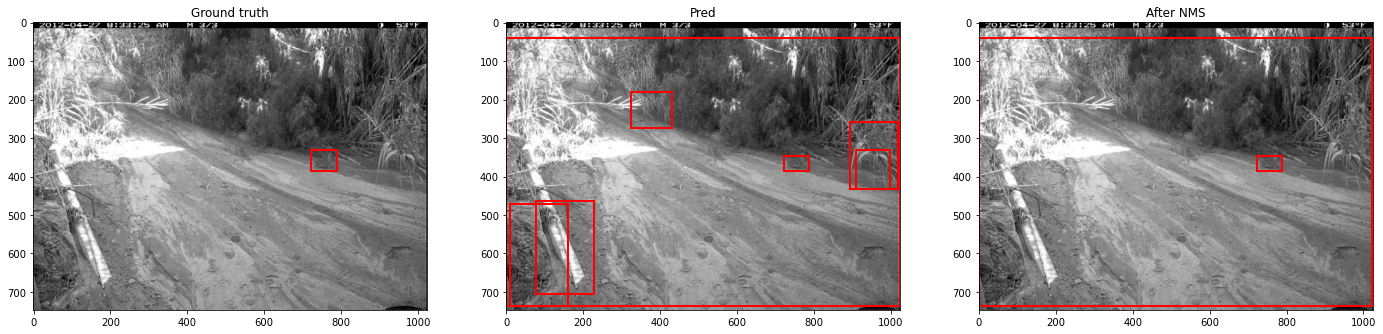

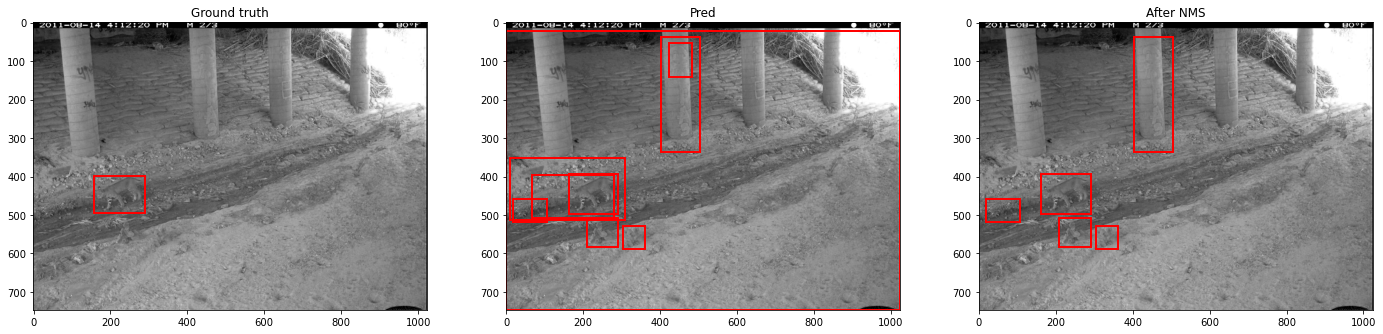

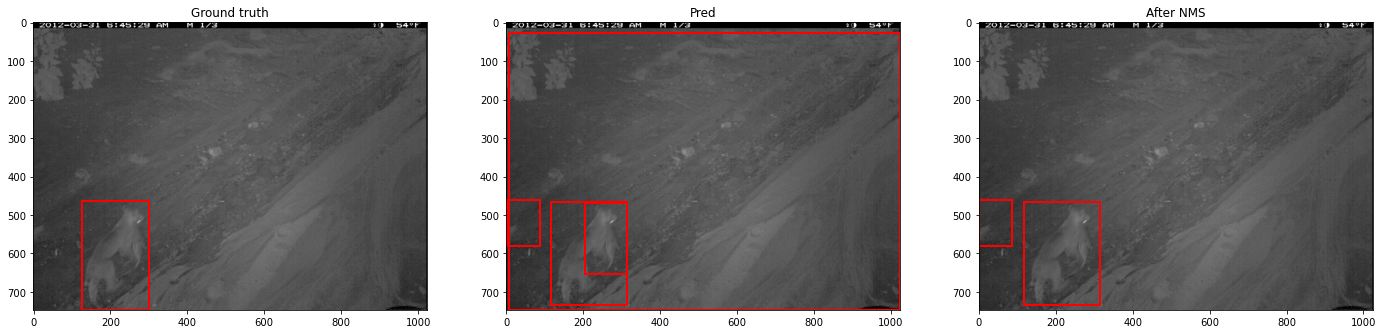

In [408]:
# Prints 10 images with the predictions before and after NMS
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.01 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

Text(0.5, 1.0, 'After NMS')

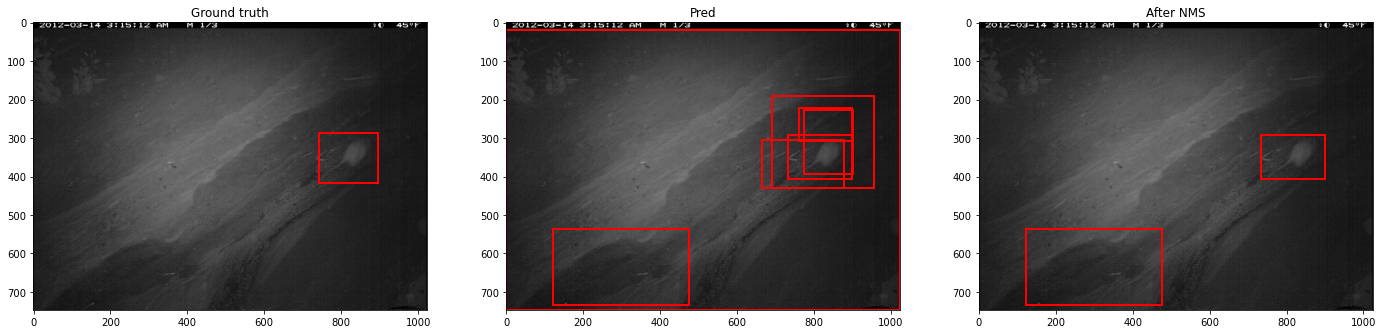

In [409]:
# Print a single image chosen by index from the last batch of 10 predictions
image_i = 0 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                          train_labels[image_i]['boxes'][0][1]), 
                         train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                         train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [410]:
boxes_to_keep

tensor([0, 3])

In [411]:
pred[image_i]['boxes'][0]

tensor([733.7464, 291.3318, 899.1647, 406.5435], device='cuda:0')

In [412]:
train_labels[image_i]['boxes']

tensor([[741., 286., 896., 418.]])

## Evalutate on COCO detection metrics

### First, create the test dataloaders

In [95]:
cis_test_valid_img,_ = get_img_with_bbox(cis_test_ann_path)   # takes about 1min to run on train data
cis_test_valid_data = CustomImageDataset(cis_test_ann_path,img_folder, cis_test_valid_img)
cis_test_valid_dataloader = DataLoader(cis_test_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [96]:
trans_test_valid_img,_ = get_img_with_bbox(trans_test_ann_path)   # takes about 1min to run on train data
trans_test_valid_data = CustomImageDataset(trans_test_ann_path,img_folder, trans_test_valid_img)
trans_test_valid_dataloader = DataLoader(trans_test_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

### Cis Test on COCO metrics
##### 'For evaluation, we consider a detected box to be correct if its IoU â‰¥ 0.5 with a ground truth box.'

We need to look at the precison score with IoU=0.5, area=all and maxDets=100.
For the recall score, by default it's IoU=0.5:IoU=0.95.

In [145]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on cis_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = cis_test_valid_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Cis Test Data - Summary')
print(" ")
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=1.93s).
____________________
Summary
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.835
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.569
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 

### Trans Test on COCO metrics

In [162]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on trans_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = trans_test_valid_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Trans Test Data - Summary')
print(" ")
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=2.81s).
____________________
Summary
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 

# Methods